<a href="https://colab.research.google.com/github/Tongkat4/MY-ANALYSIS/blob/main/SEIR(PID).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

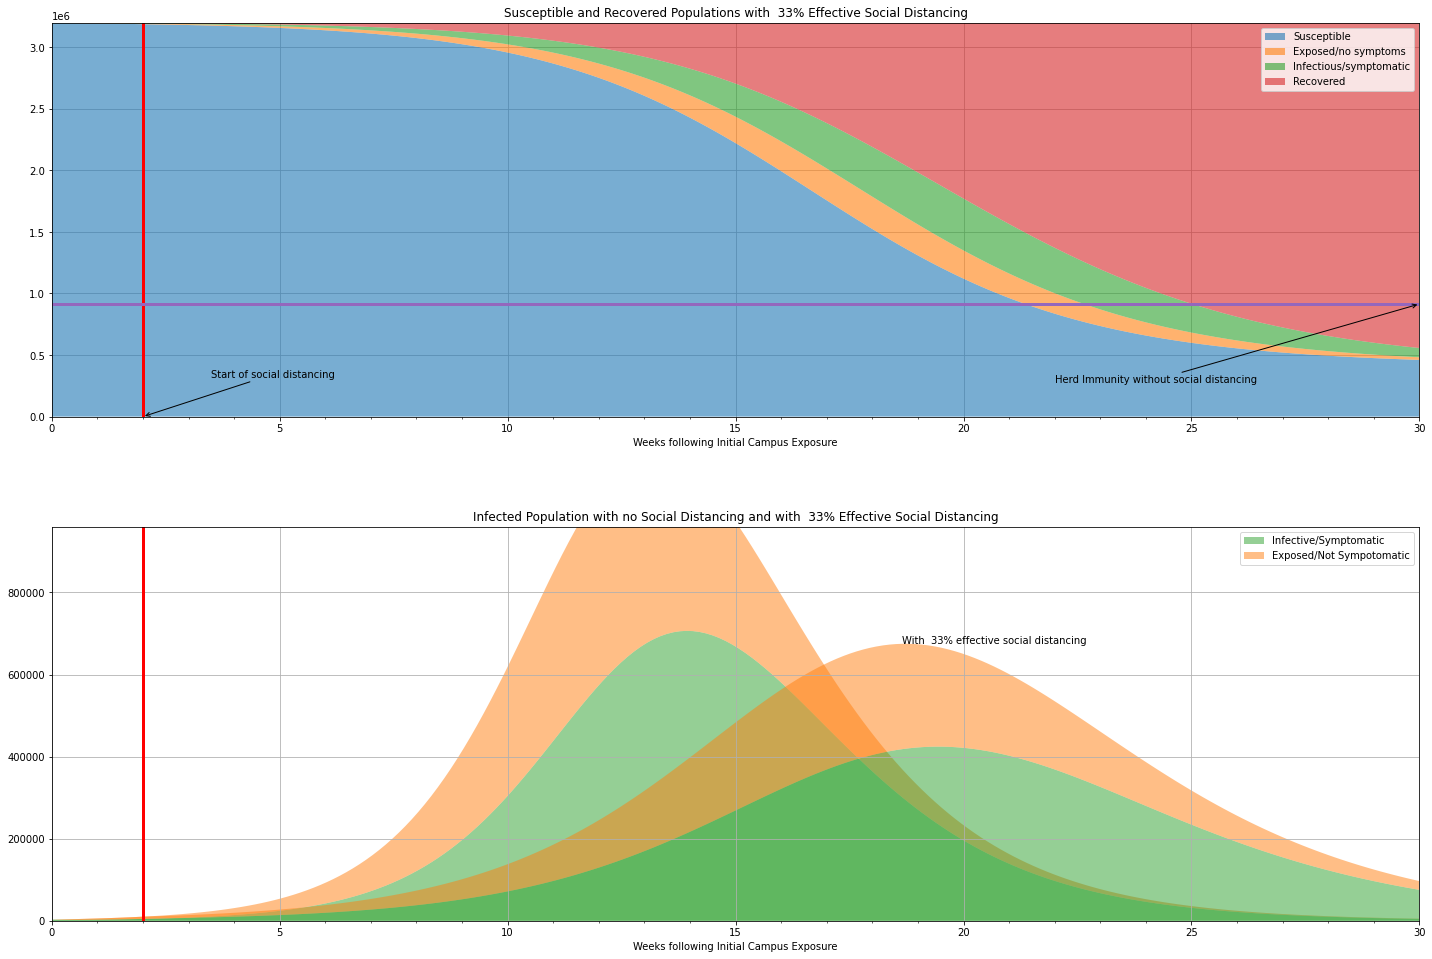

In [ ]:
#@title SEIR Model with Social Distancing { run: "auto" }
#@markdown 
#@markdown Reproduction number
R0 = 3.5 #@param {type:"slider", min:0.9, max:5, step:0.1}
#@markdown Disease periods in days
t_incubation = 8 #@param {type:"slider", min:1, max:14, step:0.1}
t_infective = 14 #@param {type:"slider", min:1, max:14, step:0.1}
#@markdown Population Size
N = 3200000 #@param {type:"slider", min:1000, max:3500000, step: 1000}
#@markdown Initial number exposed
n = 28 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = 2 #@param {type:"slider", min:0, max:30, step:0.1}
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = 33 #@param {type:"slider", min:0, max:100, step:1}

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# initial number of infected and recovered individuals
e_initial = n/N
i_initial = 0.0008
r_initial = 0.000006
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def step(t):
    return 1 if t >= 7*t_social_distancing else 0

# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u*step(t)/100)*beta * s * i
    dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 210, 210)
x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

# plot the data
fig = plt.figure(figsize=(20, 20))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Exposed/no symptoms', 
    'Infectious/symptomatic',
    'Recovered'], 
    loc='best')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start of social distancing",
    (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd Immunity without social distancing",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[1].set_xlim(0, t[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Weeks following Initial Campus Exposure')
ax[1].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()
